In [10]:
import networkx as nx
import numpy as np
import scipy.stats as sp
import random
import matplotlib.pyplot as plt
import pandas as pd
import math

from model import Simulate, Group, Agent

In [19]:
iterations = 1
n_agents = 2
T = 50
dt = .5 # TODO WORK THIS INTO EVERYTHING
timeline = np.arange(0, T + dt, dt)

# TEMP
# path_length is how far the store owner street spans
path_length = 2 * n_agents + 1

# positions of agents within first 10 position markers
agent_positions = np.random.randint(path_length, size=n_agents)

ties = [] #placeholder

simulation = Simulate(T, dt)
simulation.run(Group, Agent, n_agents, path_length, agent_positions, ties, iterations)
        
simulation

Agent 1 stimulated with strength 0.75
Agent 0 stimulated with strength 1.0
Agent 1 stimulated with strength 1.0
Agent 0 stimulated with strength 1.0
Agent 0 stimulated with strength 0.5


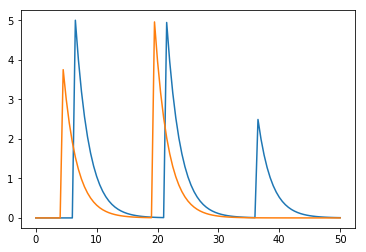

In [20]:
plt.plot(timeline, 
         simulation.output()[0]['agents'][0].data['arousal'], 
         timeline, 
         simulation.output()[0]['agents'][1].data['arousal'])

In [4]:
agent_positions

array([5, 2])

In [5]:
np.random.choice([0,3,6],1)

array([6])